In [28]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from lightgbm import plot_importance
import joblib
from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader

from hnmchallenge.evaluation.python_evaluation import map_at_k, recall_at_k
from hnmchallenge.feature_manager import FeatureManager
from hnmchallenge.datasets.last_week_last_week import LWLWDataset
from hnmchallenge.datasets.last_month_last_week_dataset import LMLWDataset
from hnmchallenge.datasets.last_month_last_day import LMLDDataset
from hnmchallenge.models.itemknn.itemknn import ItemKNN
import lightgbm as lgb


In [29]:
dataset = LMLDDataset()
dr = DataReader()

In [30]:
base_load_path = dataset._DATASET_PATH / "lgbm_models"

In [31]:
VERSION = 0
DATASET = f"cutf_100_ItemKNN_tw_True_rs_True_{VERSION}.feather"
MODEL_NAME = f"lgbm_{DATASET}.pkl"

In [32]:
model=joblib.load(base_load_path/MODEL_NAME)

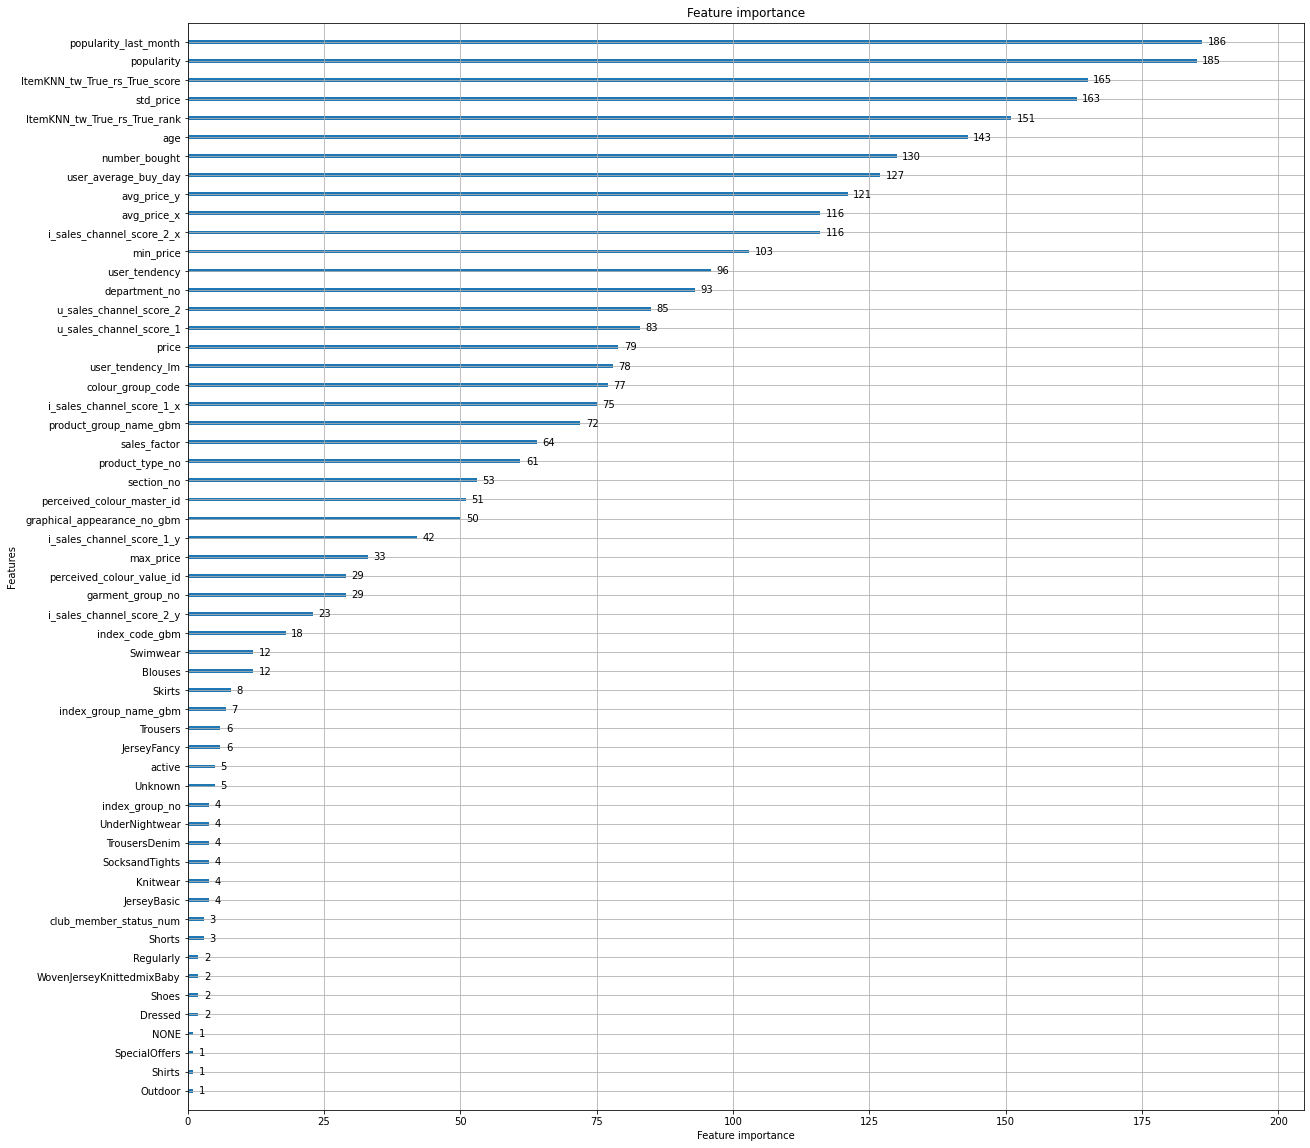

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(model, ax=ax)
plt.show()

In [34]:
model.best_iteration_

100

In [35]:
import re
features = pd.read_feather(dataset._DATASET_PATH / f"dataset_dfs/full/{DATASET}")
features = features.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

# Remember to use the bert_ntree_limit when taking the predictions

In [36]:
features.head()

,customer_id,article_id,ItemKNN_tw_True_rs_True_score,ItemKNN_tw_True_rs_True_rank,colour_group_code,i_sales_channel_score_2_x,i_sales_channel_score_1_x,department_no,Accessories,Blouses,...,user_average_buy_day,u_sales_channel_score_2,u_sales_channel_score_1,time_score,tdiff,times_item_bought,graphical_appearance_no_gbm,index_code_gbm,index_group_name_gbm,product_group_name_gbm
0,0,1971,0.002195,1.0,8,0.829041,0.170959,1747,0,0,...,95.5,1.0,0.0,NaN,NaN,NaN,0,7,4,3
1,0,1880,0.002110,2.0,73,0.705356,0.294644,1747,0,0,...,95.5,1.0,0.0,NaN,NaN,NaN,0,7,4,3
2,0,5486,0.001098,3.0,73,0.814661,0.185339,1747,0,0,...,95.5,1.0,0.0,NaN,NaN,NaN,0,7,4,3
3,0,197,0.000875,4.0,72,0.971326,0.028674,1747,0,0,...,95.5,1.0,0.0,NaN,NaN,NaN,0,7,4,3
4,0,210,0.000869,5.0,9,0.472342,0.527658,1772,0,0,...,95.5,1.0,0.0,NaN,NaN,NaN,0,7,4,3


In [37]:
features.columns

Index(['customer_id', 'article_id', 'ItemKNN_tw_True_rs_True_score',
       'ItemKNN_tw_True_rs_True_rank', 'colour_group_code',
       'i_sales_channel_score_2_x', 'i_sales_channel_score_1_x',
       'department_no', 'Accessories', 'Blouses', 'Dressed', 'DressesLadies',
       'DressesSkirtsgirls', 'JerseyBasic', 'JerseyFancy', 'Knitwear',
       'Outdoor', 'Shirts', 'Shoes', 'Shorts', 'Skirts', 'SocksandTights',
       'SpecialOffers', 'Swimwear', 'Trousers', 'TrousersDenim',
       'UnderNightwear', 'Unknown', 'WovenJerseyKnittedmixBaby',
       'garment_group_no', 'index_group_no', 'popularity',
       'popularity_last_month', 'number_bought', 'perceived_colour_master_id',
       'perceived_colour_value_id', 'product_type_no', 'section_no', 'price',
       'avg_price_x', 'max_price', 'min_price', 'std_price', 'sales_factor',
       'i_sales_channel_score_2_y', 'i_sales_channel_score_1_y', 'active',
       'age', 'club_member_status_num', 'Monthly', 'NONE', 'None', 'Regularly',
    

In [38]:
cat = [
    "index_code_gbm",
    "product_group_name_gbm",
    "index_group_name_gbm",
    "graphical_appearance_no_gbm",
]

cat_index = [i for i, c in enumerate(features.columns) if c in cat]
print(cat_index)

for col in cat:
    features[col] = pd.Categorical(features[col])

[62, 63, 64, 65]


In [39]:
customer_article_df = features[[DEFAULT_USER_COL, DEFAULT_ITEM_COL]].copy()
X = features.drop([DEFAULT_USER_COL, DEFAULT_ITEM_COL], axis=1)

In [40]:
y_pred = model.predict(X, num_iteration=model.best_iteration_)

In [41]:
customer_article_df["predicted_score"] = y_pred

In [42]:
customer_article_df

,customer_id,article_id,predicted_score
0,0,1971,1.053769
1,0,1880,1.411381
2,0,5486,1.266600
3,0,197,1.192312
4,0,210,-0.673540
...,...,...,...
137197995,1371979,13794,-1.135813
137197996,1371979,2659,-2.517687
137197997,1371979,289,-1.048743
137197998,1371979,4065,1.879676


In [43]:
sorted_scores = customer_article_df.sort_values([DEFAULT_USER_COL, "predicted_score"], ascending=[True, False])

In [44]:
sorted_scores.head(20)

,customer_id,article_id,predicted_score
1,0,1880,1.411381
2,0,5486,1.266600
3,0,197,1.192312
0,0,1971,1.053769
6,0,363,0.497297
8,0,141,0.437099
14,0,10940,0.407243
19,0,3134,0.404020
13,0,8201,0.361561
28,0,365,0.336272


In [45]:
sorted_scores_index = sorted_scores.reset_index(drop=True)

In [46]:
cutoff = sorted_scores_index.groupby(DEFAULT_USER_COL).size().values
i=0 
filter_indices = []
for cut in cutoff:
    filter_indices.extend(range(i, i+12))
    i=i+cut

In [47]:
cutoff.mean()

100.0

In [48]:
filter_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 700,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 800,
 801,
 802,
 803,
 804,
 805,
 806,
 807,
 808,
 809,
 810,
 811,
 900,
 901,
 902,
 903,
 904,
 905,
 906,
 907,
 908,
 909,
 910,
 911,
 1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1300,
 1301,
 1302,
 1303,
 1304,
 1305,
 1306,
 

In [49]:
final_df = sorted_scores_index.loc[filter_indices]

In [50]:
final_df

,customer_id,article_id,predicted_score
0,0,1880,1.411381
1,0,5486,1.266600
2,0,197,1.192312
3,0,1971,1.053769
4,0,363,0.497297
...,...,...,...
137197907,1371979,2331,1.803219
137197908,1371979,397,1.734300
137197909,1371979,373,1.733563
137197910,1371979,4614,1.677100


In [51]:
final_final_df = final_df.drop("predicted_score", axis=1)

In [52]:
dataset.create_submission(final_final_df, sub_name="gbm_knn_lmld_rs")